# 1. Оценить количество ботов, которые заходят на наш сайт, и их долю от всего трафика.
# 2. Определить, с каких источников и в какое время суток чаще всего заходят роботы.

In [2]:
#импорт библиотек
import json 
import requests
from pprint import pprint
import pandas as pd
#токен и авторизация
token = 'AgAAAABDXNAUAAbhJQqlc2F13k7XrUPDCGOvM9Y'
headers = {'Authorization': 'OAuth ' + token}
#что будем смотреть
params = {'metrics': 'ym:s:visits,ym:s:robotPercentage',
          'dimensions':'ym:s:lastsignTrafficSource,ym:s:hour',
          'date1': '2020-09-01',  
          'date2': '2020-09-30',     
          'ids': 30177909,
          'accuracy':'full',
          'limit':100000}
response = requests.get('https://api-metrika.yandex.net/stat/v1/data', params=params, headers=headers)
#основные моменты
print ('успешно?',response.status_code)
metrika_data = response.json()
print('тип данных',type(metrika_data))
print('ключи',metrika_data.keys())
print('кол-во строк',metrika_data['total_rows'])
pprint(metrika_data['data'][0:5])

успешно? 200
тип данных <class 'dict'>
ключи dict_keys(['query', 'data', 'total_rows', 'total_rows_rounded', 'sampled', 'contains_sensitive_data', 'sample_share', 'sample_size', 'sample_space', 'data_lag', 'totals', 'min', 'max'])
кол-во строк 107
[{'dimensions': [{'icon_id': '2',
                  'icon_type': 'traffic-source',
                  'id': 'organic',
                  'name': 'Search engine traffic'},
                 {'id': '16', 'name': '16:00'}],
  'metrics': [251.0, 24.70119522]},
 {'dimensions': [{'icon_id': '2',
                  'icon_type': 'traffic-source',
                  'id': 'organic',
                  'name': 'Search engine traffic'},
                 {'id': '15', 'name': '15:00'}],
  'metrics': [240.0, 26.25]},
 {'dimensions': [{'icon_id': '2',
                  'icon_type': 'traffic-source',
                  'id': 'organic',
                  'name': 'Search engine traffic'},
                 {'id': '11', 'name': '11:00'}],
  'metrics': [228.0, 25.87719

In [3]:
#Избавляемся от вложенных словарей
def getMetrikaDataInListOfDicts(metrika_data):
    list_of_dicts = []
    dimensions_list = metrika_data['query']['dimensions']
    metrics_list = metrika_data['query']['metrics']
    for data_item in metrika_data['data']:
        d = {}
        for i,dimension in enumerate(data_item['dimensions']):
            d[dimensions_list[i]] = dimension['name']
        for i,metric in enumerate(data_item['metrics']):
            d[metrics_list[i]] = metric
        list_of_dicts.append(d)
    return list_of_dicts
metrika_list_of_dicts = getMetrikaDataInListOfDicts(metrika_data)
#spprint(metrika_list_of_dicts[0:5])
metrika_df = pd.DataFrame(metrika_list_of_dicts)
metrika_df.columns=['TrafficSource','Hour', 'Visits', 'RobotPercent']
metrika_df['RobotVisits']=metrika_df['Visits']*metrika_df['RobotPercent']/100
display(metrika_df.head(10))

,TrafficSource,Hour,Visits,RobotPercent,RobotVisits
0,Search engine traffic,16:00,251.0,24.701195,62.0
1,Search engine traffic,15:00,240.0,26.250000,63.0
2,Search engine traffic,11:00,228.0,25.877193,59.0
3,Search engine traffic,13:00,227.0,28.193833,64.0
4,Search engine traffic,12:00,225.0,24.888889,56.0
5,Search engine traffic,14:00,225.0,25.777778,58.0
6,Search engine traffic,17:00,209.0,26.315789,55.0
7,Search engine traffic,10:00,186.0,19.354839,36.0
8,Search engine traffic,21:00,166.0,17.469880,29.0
9,Search engine traffic,19:00,161.0,23.602484,38.0


In [4]:
#Оценить количество ботов, которые заходят на наш сайт, и их долю от всего трафика
metrika_df_pivot_1=metrika_df.pivot_table(values=['RobotVisits','Visits'],
                                       index=['TrafficSource'],
                                       aggfunc='sum',
                                       margins=True,
                                       margins_name='Total',
                                       fill_value=0
                                       )
metrika_df_pivot_1['RobotShare']=round(metrika_df_pivot_1['RobotVisits']/metrika_df_pivot_1['Visits']*100,2)
display(metrika_df_pivot_1.sort_values('RobotVisits',ascending=True))

,RobotVisits,Visits,RobotShare
TrafficSource,,,
Recommendation system traffic,0.0,2,0.00
Cached page traffic,1.0,6,16.67
Internal traffic,3.0,10,30.00
Social network traffic,11.0,80,13.75
Link traffic,31.0,126,24.60
Direct traffic,177.0,757,23.38
Search engine traffic,739.0,3334,22.17
Total,962.0,4315,22.29


## Топ-3 канала, по которым на сайт приходят роботы: Search engine traffic, Direct traffic, Link traffic.  Search engine traffic содержит 77% всех заходов роботов от суммарных заходов роботов на наш сайт. В среднем по всем каналам 22.3% составляют заходы роботов от всего трафика.

In [5]:
#Определить, с каких источников и в какое время суток чаще всего заходят роботы
metrika_df_pivot_2=metrika_df.pivot_table(values=['RobotVisits'],
                                       index=['Hour'],
                                       columns=['TrafficSource'],
                                       aggfunc='sum',
                                       #margins=True,
                                       #margins_name='Total',
                                       fill_value=0
                                       ).reset_index()
#избавляемся от мульти-индекса
metrika_df_pivot_2.columns=list(map('_'.join,metrika_df_pivot_2))
metrika_df_pivot_2.head(10)

,Hour_,RobotVisits_Cached page traffic,RobotVisits_Direct traffic,RobotVisits_Internal traffic,RobotVisits_Link traffic,RobotVisits_Recommendation system traffic,RobotVisits_Search engine traffic,RobotVisits_Social network traffic
0,00:00,0,2,0,0,0,17,0
1,01:00,1,4,0,0,0,8,0
2,02:00,0,2,0,0,0,5,0
3,03:00,0,2,0,1,0,3,0
4,04:00,0,3,0,0,0,3,0
5,05:00,0,3,0,0,0,1,0
6,06:00,0,3,0,2,0,3,0
7,07:00,0,5,0,1,0,6,0
8,08:00,0,5,0,1,0,29,1
9,09:00,0,12,1,1,0,36,1


<Figure size 432x288 with 0 Axes>

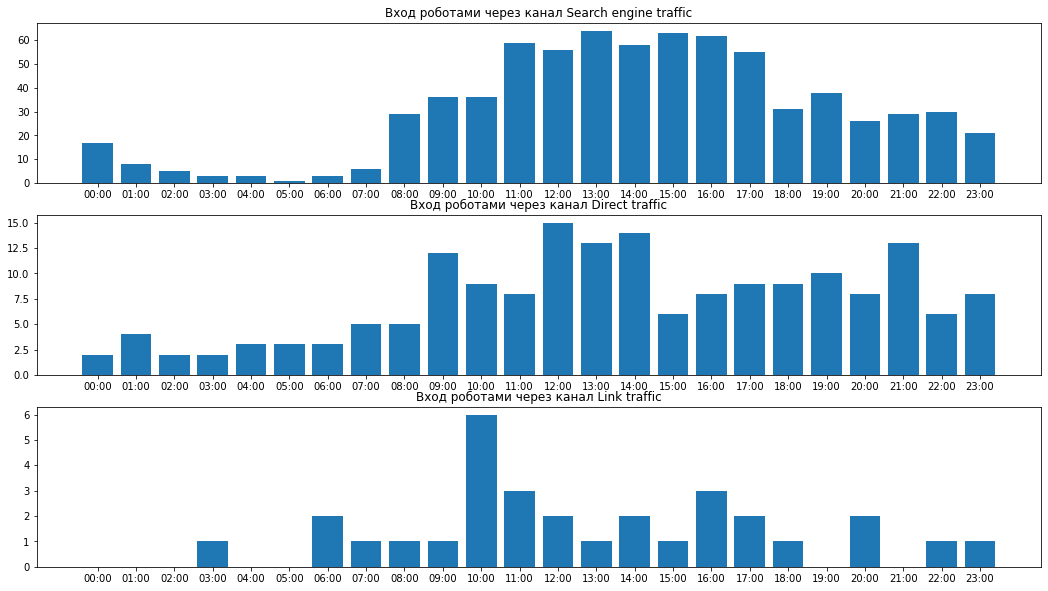

In [6]:
#визуализация
import matplotlib.pyplot as plt
import matplotlib as mp
import seaborn as sns
import numpy as np
%matplotlib inline
#Чертим график
fig = plt.figure()
fig, axes = plt.subplots(3,1, figsize=(18,10))
axes[0].bar(x = metrika_df_pivot_2['Hour_'], height = metrika_df_pivot_2['RobotVisits_Search engine traffic'])
axes[0].set_title('Вход роботами через канал Search engine traffic')
axes[1].bar(x = metrika_df_pivot_2['Hour_'], height = metrika_df_pivot_2['RobotVisits_Direct traffic'])
axes[1].set_title('Вход роботами через канал Direct traffic')
axes[2].bar(x = metrika_df_pivot_2['Hour_'], height = metrika_df_pivot_2['RobotVisits_Link traffic'])
axes[2].set_title('Вход роботами через канал Link traffic')
plt.show()

## Как было выяснено на предыдущем этапе, каналы Search engine traffic, Direct traffic, Link traffic являются самыми популярными у роботов, причем в канале Search engine traffic сосредоточено 77% посещений роботов от суммарного посещения роботами через все каналы. Из графиков видно, что роботы чаще всего пользуются каналом Search engine traffic и чаще всего посещают сайт через данный канал с 11:00 до 17:00 (более 50 заходов каждый час). Каналом Direct Traffic роботы пользуются в основном с 12:00 до 14:00, а также в 9:00 и в 21:00, и заходят в эти часы более 10 раз. Через канал Link Traffic роботы в основном входили в 10:00 (6 раз).